In [1]:
from sympy import Symbol, plot, solve, Sum, Rational, floor, maximum
from sympy.stats import Hypergeometric, density, Binomial
from sympy import Function

n1 = Symbol("n1")

In [276]:
floor(2.3)

2

In [2]:
bucket = 1
items = 1000
item = 500
trials = 2
assert items>item, "itemas > item"
print("buckets:", trials+1)
print(f"Items: 0-{items-1}: \n" + "".join("[_]" if i!=bucket else f"[{item}]" for i in range(trials+1)))
print()
print(f"Items: 0-{1}: \n" + "".join("[_]" if i!=bucket else f"[{item/items:f}]" for i in range(trials+1)))

print(density(Hypergeometric('H', items-1, item, trials))(bucket).evalf())
density(Binomial("X", trials, item/items))(bucket)

buckets: 3
Items: 0-999: 
[_][500][_]

Items: 0-1: 
[_][0.500000][_]
0.500500500500501


0.500000000000000

In [674]:
from functools import lru_cache
from itertools import pairwise

from sympy import S

#@lru_cache
def pb(bucket, items, buckets):
    trials = buckets -1 
    return density(Hypergeometric('H', items-1, n1, trials))(bucket)

def hp(buckets, items):
    return (pb(i, items, buckets) for i in range(buckets))

def p_cuts(buckets, items):
    return (solve(a-b) for a,b in pairwise(hp(buckets, items)))

def opt_cuts(buckets, items):
    yield 0
    cuts = p_cuts(buckets, items)
    cut = next(cuts)
    yield cut[0] if isinstance(cut,list) else cut
    for cut in cuts:
        yield cut[1]
    yield items-1
        
def round_cuts(buckets, items):
    return (floor(i) for i in opt_cuts(buckets, items))

# @lru_cache
def cuts(buckets, items):
    r_c = round_cuts(buckets, items)
    a, b = 0, next(r_c)
    for i in r_c:
        b = i
        yield a, b  
        a = b+1


class opt_min(Function):
    @classmethod
    def eval(cls, n, buckets, items):
        # print('min', n)
        if n == 0:
            return 0
        else:
            sol = solve(pb(n, items, buckets)-pb(n-1, items, buckets))
            return floor(sol[0])+1
        
class opt_max(Function):
    @classmethod
    def eval(cls, n, buckets, items):
        # print('max', n, buckets, items)
        if n == buckets-1:
            return items-1
        else:
            sol = solve(pb(n, items, buckets)-pb(n+1,items, buckets), n1)
            return floor(sol[0])

def P(buckets, items):
    # min included max not included, as python convention
    if buckets ==1 :
        return 1

    #opt_min = Function("optmin")
    #opt_max = Function("optmax")
    s = sum(Sum(pb(b, items, buckets)* P(buckets-1,items-n1) * P(buckets-1,n1+1), 
                (n1, opt_min(b, buckets, items), opt_max(b, buckets, items))) for b in range(buckets))
    #b1 = Symbol("b1")
    #s = Sum(Sum(pb(b1, items, buckets)* P(buckets-1,items-n1) * P(buckets-1,n1+1),
    #             (n1, opt_min(b1, buckets, items), opt_max(b1, buckets, items))), (b1, 0, bucket))
    return s * (items)**-1

In [676]:
P(2, 3)

0.333333333333333*Sum(n1/2, (n1, 2, 2)) + 0.333333333333333*Sum(1 - n1/2, (n1, 0, 1))

In [668]:
P(3,3)# .evalf()

IndexError: list index out of range

In [300]:
list(p_cuts(3,3))

[[1/3, 2], [0, 5/3]]

In [301]:
list(opt_cuts(3,3))

[0, 1/3, 5/3, 2]

In [305]:
P(3, 3)

IndexError: list index out of range

In [191]:
P(2, 3).evalf().evalf().evalf()

TypeError: pn takes exactly 2 arguments (1 given)

In [115]:
p = Po(2, 0, 2)
p

Sum(n1/2, (n1, 2, 2))/3 + Sum(1 - n1/2, (n1, 0, 1))/3

In [63]:
P(3, 0, 100) #.evalf()

IndexError: list index out of range

In [56]:
P(6, 0, 100).evalf()

0.292234077184281

Buckets: 3


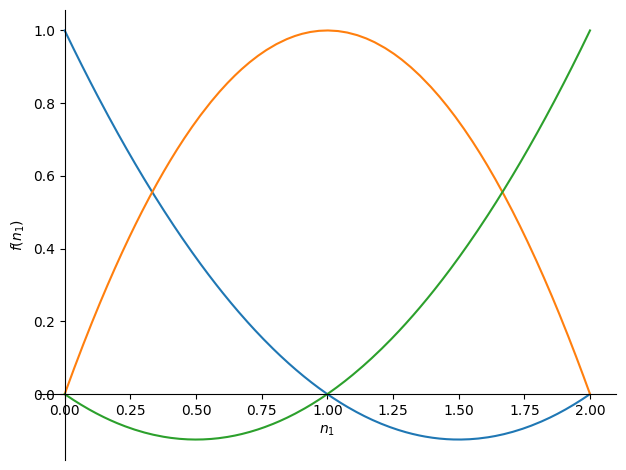

In [472]:
buckets = 3
print("Buckets:",buckets)
plot(*hp(buckets, buckets), (n1, 0,buckets-1))
plot(*hp(buckets, buckets), (n1, 0,buckets-1))


Buckets: 3


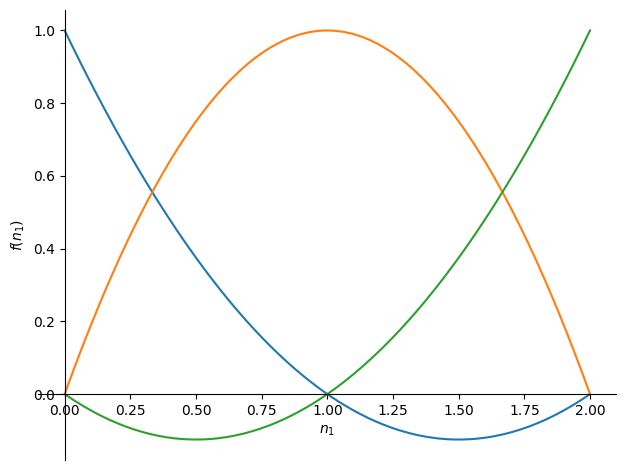

In [320]:
buckets = 3
print("Buckets:",buckets)
plot(*hp(buckets, 3), (n1, 0,2))
plot(*hp(buckets, 11), (n1, 0,10))
plot(*hp(4, 4), (n1, 0,3))
plot(*hp(4, 5), (n1, 0,4))

In [151]:
list(hp(4, 5))[0].evalf(subs={n1:0})

1.00000000000000

In [2]:
from sympy import Symbol, plot, solve, Sum, Rational, floor, maximum
from sympy.stats import Hypergeometric, density, Binomial
from sympy import Function

n1 = Symbol("n1")
from functools import lru_cache

In [386]:
#@lru_cache
def pb(buckets: int, items: int, bucket: int):
    trials = buckets -1 
    return density(Hypergeometric('H', items-1, n1, trials))(bucket)

def opt(buckets:int, items:int):
    sols= [0]
    current = 0 
    for i in range(0, buckets):
        sol=solve(pb(buckets, items,i)-pb(buckets, items, i+1))
        for j in sol:
            if j> current:
                sols.append(j)
                current = j
                break
        # print(sol)
    sols.append(items-1)
    return sols

def int_opt(buckets, items):
    opts = (int(i) for i in opt(buckets, items))
    i = next(opts)
    for k in opts:
        f = k if k>i else i
        yield i,f
        i = f+1

#@lru_cache
def P(buckets, items):
    print(f"P({buckets},{items})")
    # min included max not included, as python convention

    if buckets in (0,1):
        return 1
    if items == buckets: # good but take out for testing everything works
        return 1 
    if items < buckets:
        return 1
    s = 0
    opts = int_opt( buckets, items)
    
    for b in range(buckets):
        mi, ma= next(opts)
        print(f"P({buckets},{items})","mi,ma",mi,ma)
        nv = 0
        for n in range(mi, ma+1):
            v = pb(buckets, items, b).subs({n1:n})* P(b, n-1) * P(buckets-1-b, items-n-1)
            nv+=v
            print(f"P({buckets},{items}) {b=} {n=} {v=}" , "cont:", pb(buckets, items, b).subs({n1:n}) , f"{v=}")
            print(nv)
        s+=nv
        # print(f"{s=}")
    #print("final")
    #print(f"{s=}")
    #print()
    return s / items

In [387]:
pb(2, 4, 0).subs({n1:1})
list(int_opt(2, 4))
P(2,3)  


P(2,3)
P(2,3) mi,ma 0 1
P(0,-1)
P(1,2)
P(2,3) b=0 n=0 v=1 cont: 1 v=1
1
P(0,0)
P(1,1)
P(2,3) b=0 n=1 v=1/2 cont: 1/2 v=1/2
3/2
s=3/2
P(2,3) mi,ma 2 2
P(1,1)
P(0,0)
P(2,3) b=1 n=2 v=1 cont: 1 v=1
1
s=5/2
s=5/2


5/6

In [389]:
P(2,5)

P(2,5)
P(2,5) mi,ma 0 2
P(0,-1)
P(1,4)
P(2,5) b=0 n=0 v=1 cont: 1 v=1
1
P(0,0)
P(1,3)
P(2,5) b=0 n=1 v=3/4 cont: 3/4 v=3/4
7/4
P(0,1)
P(1,2)
P(2,5) b=0 n=2 v=1/2 cont: 1/2 v=1/2
9/4
s=9/4
P(2,5) mi,ma 3 4
P(1,2)
P(0,1)
P(2,5) b=1 n=3 v=3/4 cont: 3/4 v=3/4
3/4
P(1,3)
P(0,0)
P(2,5) b=1 n=4 v=1 cont: 1 v=1
7/4
s=4
s=4


4/5

In [331]:
P(2,3)  

P(2,3)
P(2,3) mi,ma 0 1
P(0,0)
P(3,2)


AssertionError: irregular place to be

In [94]:
opt(3, 2)

[0, 1, 1]

In [84]:
P(1,2)

P( 1 2 )


1

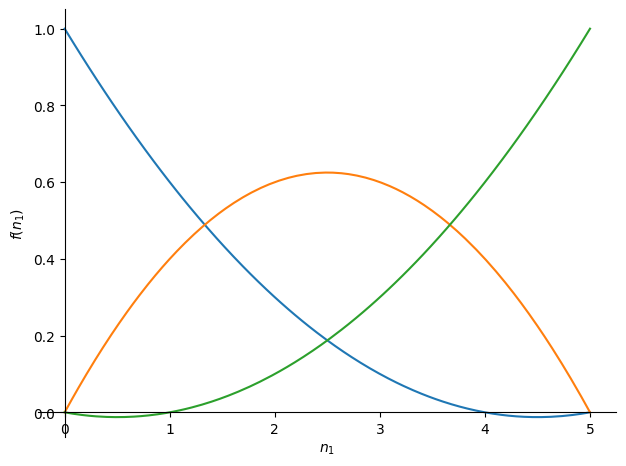

[0, 4/3, 11/3, 5]

In [194]:
items, buckets = 6,3
plot(*[pb(buckets, items,i ) for i in range(buckets)],(n1,0,items-1))
opt(buckets, items)

In [221]:
list(int_opt())

[(0, 1), (2, 3), (4, 5)]

In [172]:
print(*[opt_min(i,3,3) for i in range(3)])
print(*[opt_max(i,3,3) for i in range(3)])


0 1 2
0 1 2


P( 3 3 )
mi ma 0 0
P( 0 0 )
P( 2 2 )
mi ma 0 0
P( 0 0 )
P( 1 1 )
2 0 1


IndexError: list index out of range